# Recommender system - Matrix Factorization

data: https://www.kaggle.com/sengzhaotoo/movielens-small \
Referred to:
-  https://lsjsj92.tistory.com/568
- Source code:https://github.com/lsjsj92/recommender_system_with_Python/blob/master/004.%20recommender%20system%20basic%20with%20Python%20-%203%20Matrix%20Factorization.ipynb
- https://github.com/nikitaa30/Recommender-Systems/blob/master/matrix_factorisation_svd.py

In [1]:
from sklearn.decomposition import TruncatedSVD
from scipy.sparse.linalg import svds

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [3]:
rating = pd.read_csv("data/ratings.csv")
movie = pd.read_csv("data/movies.csv")

In [4]:
rating.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [5]:
movie.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [8]:
print(rating.shape)
print(movie.shape)

(100004, 4)
(9125, 3)


## Data preprocessing

In [9]:
rating.drop('timestamp', axis = 1, inplace = True)
rating.head()

,userId,movieId,rating
0,1,31,2.5
1,1,1029,3.0
2,1,1061,3.0
3,1,1129,2.0
4,1,1172,4.0


In [10]:
movie.drop('genres', axis = 1, inplace = True)
movie.head()

,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)


In [11]:
# merge two dataframes with common column 
user_movie = pd.merge(rating, movie, on = 'movieId')
user_movie.head()

,userId,movieId,rating,title
0,1,31,2.5,Dangerous Minds (1995)
1,7,31,3.0,Dangerous Minds (1995)
2,31,31,4.0,Dangerous Minds (1995)
3,32,31,4.0,Dangerous Minds (1995)
4,36,31,3.0,Dangerous Minds (1995)


In [12]:
user_movie.shape

(100004, 4)

In [13]:
# create a pivot_table with value of rating, column of movie title, and index of user id
user_movie_rating = user_movie.pivot_table('rating', index = 'userId', columns = 'title').fillna(0)
user_movie_rating.shape

(671, 9064)

In [14]:
user_movie_rating.head()

title,"""Great Performances"" Cats (1998)",$9.99 (2008),'Hellboy': The Seeds of Creation (2004),'Neath the Arizona Skies (1934),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),...,Zulu (1964),Zulu (2013),[REC] (2007),eXistenZ (1999),loudQUIETloud: A Film About the Pixies (2006),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931),İtirazım Var (2014)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Recommender - Movie

Convert user-movie data to **movie-user** data and create a logic to recommend similar movies with selections

In [16]:
movie_user_rating = user_movie_rating.values.T
movie_user_rating.shape

(9064, 671)

In [17]:
type(movie_user_rating)

numpy.ndarray

### SVD (Singular Value Decomposition)

In [18]:
# reduce to 12 dimensions
SVD = TruncatedSVD(n_components = 12)
matrix = SVD.fit_transform(movie_user_rating)
matrix.shape

(9064, 12)

In [19]:
matrix[0]

array([ 0.01227491,  0.00250962,  0.0155489 , -0.0339734 , -0.0144335 ,
        0.00347128, -0.00239835,  0.04443985, -0.01566012, -0.02046381,
        0.01158797, -0.00496937])

In [21]:
# get the pearson corr coefficient of the data
corr = np.corrcoef(matrix)
corr.shape

(9064, 9064)

In [22]:
corr2 = corr[:200, :200]
corr2.shape

(200, 200)

<AxesSubplot:>

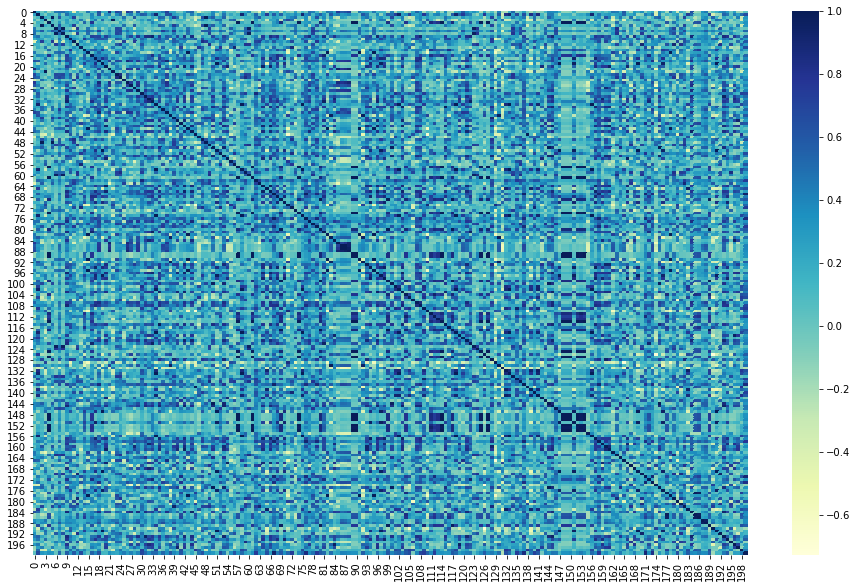

In [24]:
plt.figure(figsize = (16,10))
sns.heatmap(corr2, cmap="YlGnBu")


In [28]:
for i in user_movie_rating.columns:
    if "Avengers" in i:
        print(i)

Avengers, The (1998)
Avengers, The (2012)
Avengers: Age of Ultron (2015)


From this heatmap, get movies with high correlation coefficient with a certain movie.

In [31]:
movie_title = user_movie_rating.columns
movie_title_list = list(movie_title)
movie_avengers = movie_title_list.index("Avengers: Age of Ultron (2015)")

In [32]:
corr_movie_avengers = corr[movie_avengers]
list(movie_title[(corr_movie_avengers >= 0.9)])[:50]

['2 Guns (2013)',
 '2012 (2009)',
 '300: Rise of an Empire (2014)',
 'Adjustment Bureau, The (2011)',
 'Adventures of Tintin, The (2011)',
 'After Earth (2013)',
 'Alex Cross (2012)',
 'Amazing Spider-Man, The (2012)',
 'Ant-Man (2015)',
 'Avengers, The (2012)',
 'Avengers: Age of Ultron (2015)',
 'Babylon A.D. (2008)',
 'Batman v Superman: Dawn of Justice (2016)',
 'Battle: Los Angeles (2011)',
 'Bee Movie (2007)',
 'Big Hero 6 (2014)',
 'Bolt (2008)',
 'Bounty Hunter, The (2010)',
 'Bourne Legacy, The (2012)',
 'Brave (2012)',
 'Captain America: Civil War (2016)',
 'Captain America: The First Avenger (2011)',
 'Captain America: The Winter Soldier (2014)',
 'Cats & Dogs (2001)',
 'Chronicle (2012)',
 'Colombiana (2011)',
 'Dark Shadows (2012)',
 'Deadfall (2012)',
 'Edge of Tomorrow (2014)',
 'Eight Legged Freaks (2002)',
 'Elysium (2013)',
 'Failure to Launch (2006)',
 'Fantastic Four (2015)',
 'Fantastic Four: Rise of the Silver Surfer (2007)',
 'Furious 7 (2015)',
 'G.I. Joe: The R

Movies related to Avengers: Age of Ultron (2015) are recommended.\
We can observe some Avengers series, and Marvel movies like Ant-Man, Guardians of the Galaxy.

## Recommender - User

We investigated movie-based recommendation algorithm above.\
Now we will look for user-based recommendation algorithm

In [35]:
df_ratings = pd.read_csv("data/ratings.csv")
df_movie = pd.read_csv("data/movies.csv")

In [36]:
df_user_movie_ratings = df_ratings.pivot(
    index='userId',
    columns='movieId',
    values='rating'
).fillna(0)

In [41]:
# user-movie pivot table
df_user_movie_ratings.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


1. Convert pivot table to matrix
2. Get average ratings each users give to movies
3. Get user-average data by subtracting 1 from 2

In [43]:
# pivot_table to numpy matrix
matrix = df_user_movie_ratings.values

# user_ratings_mean: user's ratings mean
user_ratings_mean = np.mean(matrix, axis = 1)

# R_user_mean : user-movie - user_ratings_mean
matrix_user_mean = matrix - user_ratings_mean.reshape(-1, 1)

In [44]:
matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       [5., 0., 0., ..., 0., 0., 0.]])

In [45]:
matrix.shape

(671, 9066)

In [46]:
user_ratings_mean.shape

(671,)

In [47]:
matrix_user_mean.shape

(671, 9066)

In [48]:
pd.DataFrame(matrix_user_mean, columns = df_user_movie_ratings.columns).head()

movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
0,-0.005625,-0.005625,-0.005625,-0.005625,-0.005625,-0.005625,-0.005625,-0.005625,-0.005625,-0.005625,...,-0.005625,-0.005625,-0.005625,-0.005625,-0.005625,-0.005625,-0.005625,-0.005625,-0.005625,-0.005625
1,-0.029230,-0.029230,-0.029230,-0.029230,-0.029230,-0.029230,-0.029230,-0.029230,-0.029230,3.970770,...,-0.029230,-0.029230,-0.029230,-0.029230,-0.029230,-0.029230,-0.029230,-0.029230,-0.029230,-0.029230
2,-0.020075,-0.020075,-0.020075,-0.020075,-0.020075,-0.020075,-0.020075,-0.020075,-0.020075,-0.020075,...,-0.020075,-0.020075,-0.020075,-0.020075,-0.020075,-0.020075,-0.020075,-0.020075,-0.020075,-0.020075
3,-0.097838,-0.097838,-0.097838,-0.097838,-0.097838,-0.097838,-0.097838,-0.097838,-0.097838,3.902162,...,-0.097838,-0.097838,-0.097838,-0.097838,-0.097838,-0.097838,-0.097838,-0.097838,-0.097838,-0.097838
4,-0.043128,-0.043128,3.956872,-0.043128,-0.043128,-0.043128,-0.043128,-0.043128,-0.043128,-0.043128,...,-0.043128,-0.043128,-0.043128,-0.043128,-0.043128,-0.043128,-0.043128,-0.043128,-0.043128,-0.043128


Converted user-movie pivot table to matrix_user_mean\
The changes made are:
1. Data of the ratings 671 users gave to 9066 movies
2. Calculate the mean of each users' ratings
3. Subtract 1-2

### SVD: Matrix Factorization

We will use scipy Truncated SVD this time.\
Scipy returns U, Sigma, Vt converted values while scikit learn TruncatedSVD does not.\

Scipy: Truncated SVD scipy.sparse.linalg.svds


In [49]:
U, sigma, Vt = svds(matrix_user_mean, k = 12)

In [50]:
print(U.shape)
print(sigma.shape)
print(Vt.shape)

(671, 12)
(12,)
(12, 9066)


In [51]:
# to create symmetric matrix including 0, should use numpy diag
sigma = np.diag(sigma)

In [52]:
sigma.shape

(12, 12)

In [53]:
sigma[0]

array([105.72437051,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ])

In [54]:
sigma[1]

array([  0.        , 110.15522471,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ])

Changes made until now:
1. Original user-movie ratings matrix
2. Subtract this from user average ratings and create matrix_useer_mean matrix
3. Get U, Sigma, Vt from value obtained from 2
4. Convert sigma matrix to symmetric matrix(numpy diag)

In [55]:
svd_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)

In [56]:
df_svd_preds = pd.DataFrame(svd_user_predicted_ratings, columns = df_user_movie_ratings.columns)
df_svd_preds.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
0,-0.079686,0.021779,-0.013837,-0.005870,-0.028877,0.032371,0.000715,-0.004428,-0.005219,0.038195,...,-0.004324,-0.004352,0.010478,-0.004256,-0.003944,-0.005674,0.018157,-0.005575,-0.005297,-0.003766
1,1.428452,1.608841,0.529476,0.168278,0.520809,1.107473,0.529719,0.089376,0.296270,1.970031,...,0.013227,-0.002275,0.020680,-0.005245,-0.007644,-0.021019,0.031243,-0.000957,-0.000753,0.026901
2,0.977246,0.396971,0.000299,0.027444,0.021287,0.141458,-0.057134,0.031633,-0.012538,0.383576,...,0.002761,0.004907,-0.014190,-0.000251,-0.006007,-0.003189,-0.026916,0.014637,0.013287,-0.005741
3,1.870844,1.169993,0.252202,0.094831,-0.181713,-0.511953,-0.027820,-0.143080,0.013247,1.461694,...,0.026412,-0.027245,0.054681,0.018450,0.034544,-0.035740,0.088889,-0.019365,-0.017113,0.066559
4,1.182777,0.924903,0.075998,0.061505,0.602680,-0.159825,0.339925,0.081534,-0.079666,0.535018,...,-0.029124,-0.029357,0.009064,-0.029092,-0.030890,-0.057453,0.026344,-0.024027,-0.024614,-0.032752


In [57]:
df_svd_preds.shape


(671, 9066)

In [58]:
def recommend_movies(df_svd_preds, user_id, ori_movies_df, ori_ratings_df, num_recommendations=5):
    
    # since index, user_id - 1
    user_row_number = user_id - 1 
    
    # sort movies according to high ratings
    sorted_user_predictions = df_svd_preds.iloc[user_row_number].sort_values(ascending=False)
    
    # get user_id data from original ratings data
    user_data = ori_ratings_df[ori_ratings_df.userId == user_id]
    
    # merge user_data and original movie_data
    user_history = user_data.merge(ori_movies_df, on = 'movieId').sort_values(['rating'], ascending=False)
    
    # remove movie the user watched
    recommendations = ori_movies_df[~ori_movies_df['movieId'].isin(user_history['movieId'])]
    
    # merge recommendations with high user ratings
    recommendations = recommendations.merge( pd.DataFrame(sorted_user_predictions).reset_index(), on = 'movieId')
    
    # sort_values
    recommendations = recommendations.rename(columns = {user_row_number: 'Predictions'}).sort_values('Predictions', ascending = False).iloc[:num_recommendations, :]
                      

    return user_history, recommendations

In [66]:
already_rated, predictions = recommend_movies(df_svd_preds, 200, df_movie, df_ratings, 10)

In [67]:
already_rated.head()

,userId,movieId,rating,timestamp,title,genres
65,200,2571,5.0,1437932708,"Matrix, The (1999)",Action|Sci-Fi|Thriller
47,200,1682,5.0,1437933004,"Truman Show, The (1998)",Comedy|Drama|Sci-Fi
34,200,1270,5.0,1437932711,Back to the Future (1985),Adventure|Comedy|Sci-Fi
45,200,1625,5.0,1437933483,"Game, The (1997)",Drama|Mystery|Thriller
166,200,36529,5.0,1437933015,Lord of War (2005),Action|Crime|Drama|Thriller|War


In [68]:
predictions

,movieId,title,genres,Predictions
3760,4993,"Lord of the Rings: The Fellowship of the Ring,...",Adventure|Fantasy,3.385399
4271,5952,"Lord of the Rings: The Two Towers, The (2002)",Adventure|Fantasy,3.301406
4884,7153,"Lord of the Rings: The Return of the King, The...",Action|Adventure|Drama|Fantasy,3.255567
6689,58559,"Dark Knight, The (2008)",Action|Crime|Drama|IMAX,2.907371
2781,3578,Gladiator (2000),Action|Adventure|Drama,2.734390
275,318,"Shawshank Redemption, The (1994)",Crime|Drama,2.441090
6716,59315,Iron Man (2008),Action|Adventure|Sci-Fi,2.246475
5979,33794,Batman Begins (2005),Action|Crime|IMAX,2.202902
7171,72998,Avatar (2009),Action|Adventure|Sci-Fi|IMAX,2.026921
501,589,Terminator 2: Judgment Day (1991),Action|Sci-Fi,1.919666


Created recommendation based on users' watched list and ratings